In [1]:
import sys
sys.path.append("../")

import numpy as np
import numpy.linalg as npla
import scipy
import scipy.linalg as sla
import pickle
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
%matplotlib inline

from utils.saddle_sliding import SaddleSlidingRunner
from methods.saddle import SaddleSliding, Extragradient, extragradient_solver, Logger
from oracles.saddle import ArrayPair, RobustLinearOracle, create_robust_linear_oracle, OracleLinearComb

from experiment_utils import gen_oracles_for_sliding

In [2]:
n_one = 5
d = 3
num_summands = 4
noise = 0.5
regcoef_x = 0.2
regcoef_y = 0.2

oracle_sum, oracle_phi, oracle_g = gen_oracles_for_sliding(n_one, d, num_summands, noise, regcoef_x, regcoef_y)
z_0 = ArrayPair.zeros(d)

In [3]:
%%time
logger_extragradient = Logger()
extragradient = Extragradient(
    oracle=oracle_sum, 
    stepsize=0.01, 
    z_0=z_0, 
    tolerance=1e-17, 
    stopping_criteria='grad_abs', 
    logger=logger_extragradient
)
extragradient.run(100000)
z_true = logger_extragradient.z_star
print('steps to convergence: ', logger_extragradient.num_steps)
print('grad norm: ', oracle_sum.grad(z_true).norm())

steps to convergence:  445
grad norm:  3.0270143439544665e-09
CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 30.5 ms


In [4]:
%%time
logger_sliding = Logger(z_true=z_true)
sliding = SaddleSliding(
    oracle_g, 
    oracle_phi, 
    stepsize_outer=0.02, 
    stepsize_inner=0.01, 
    inner_solver=extragradient_solver, 
    inner_iterations=1000, 
    z_0=z_0,
    logger=logger_sliding
)
sliding.run(500)

CPU times: user 28.6 s, sys: 11.2 ms, total: 28.6 s
Wall time: 28.6 s


In [5]:
%%time
logger_extragradient_again = Logger(z_true=z_true)
extragradient_again = Extragradient(
    oracle=oracle_sum, 
    stepsize=0.01, 
    z_0=z_0, 
    tolerance=1e-17, 
    stopping_criteria='grad_abs', 
    logger=logger_extragradient_again
)
extragradient_again.run(500)

CPU times: user 33.9 ms, sys: 0 ns, total: 33.9 ms
Wall time: 32.7 ms


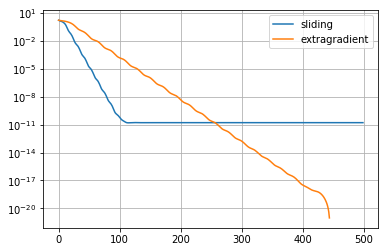

In [6]:
plt.plot(logger_sliding.dist_to_opt, label='sliding')
plt.plot(logger_extragradient_again.dist_to_opt, label='extragradient')

plt.yscale('log')
plt.legend()
plt.grid()